## Import Required Libraries

We import libraries for:
- Data manipulation
- Visualization
- Sentiment analysis
- Model evaluation

In [1]:
# Data manipulation
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# NLTK sentiment analyzer (VADER)
from nltk.sentiment import SentimentIntensityAnalyzer
# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
# Transformer-based sentiment analysis
from transformers import pipeline, AutoTokenizer

c:\Users\ezio9\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Prepare Dataset

- Load the CSV file
- Keep only review text and rating
- Remove missing values

In [2]:
df = pd.read_csv("Datafiniti_Hotel_Reviews.csv")
df = df[['reviews.text', 'reviews.rating']]
df = df.dropna()

df.head()

,reviews.text,reviews.rating
0,Our experience at Rancho Valencia was absolute...,5.0
1,Amazing place. Everyone was extremely warm and...,5.0
2,We booked a 3 night stay at Rancho Valencia to...,5.0
3,Currently in bed writing this for the past hr ...,2.0
4,I live in Md and the Aloft is my Home away fro...,5.0


In [3]:
# Function to convert numeric rating into sentiment label
def rating_to_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

df['true_sentiment'] = df['reviews.rating'].apply(rating_to_sentiment)

## Sentiment Analysis Using VADER (NLTK)

In [4]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()
# Function to compute VADER polarity scores for a given text
def get_vader_scores(text):
    return sia.polarity_scores(text)


# Function to convert compound score into sentiment label
def vader_label(score):
   
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"


# Apply VADER to all review texts
vader_results = df['reviews.text'].apply(get_vader_scores)

# Convert results into DataFrame
vader_df = pd.DataFrame(vader_results.tolist())

# Merge VADER scores with original dataset
df = pd.concat([df, vader_df], axis=1)

# Create predicted sentiment column based on compound score
df['vader_sentiment'] = df['compound'].apply(vader_label)

# Preview results
df.head()

,reviews.text,reviews.rating,true_sentiment,neg,neu,pos,compound,vader_sentiment
0,Our experience at Rancho Valencia was absolute...,5.0,positive,0.0,0.669,0.331,0.9162,positive
1,Amazing place. Everyone was extremely warm and...,5.0,positive,0.0,0.654,0.346,0.9650,positive
2,We booked a 3 night stay at Rancho Valencia to...,5.0,positive,0.0,0.727,0.273,0.9748,positive
3,Currently in bed writing this for the past hr ...,2.0,negative,0.0,1.000,0.000,0.0000,neutral
4,I live in Md and the Aloft is my Home away fro...,5.0,positive,0.0,0.838,0.162,0.8713,positive


## Sentiment Analysis Using RoBERTa (Transformer Model)

In this section, we use a pre-trained transformer model:
**cardiffnlp/twitter-roberta-base-sentiment**


In [5]:
def roberta_label(label):
    if label == "LABEL_2":
        return "positive"
    elif label == "LABEL_1":
        return "neutral"
    else:
        return "negative"

In [6]:
# Load Pretrained Model and Tokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment",
    model_max_length=512
)

# Create sentiment analysis pipeline
roberta_sentiment = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    tokenizer=tokenizer,
    device=0  # Use GPU
)

c:\Users\ezio9\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# Remove missing reviews
df = df.dropna(subset=['reviews.text']).copy()

texts = df['reviews.text'].astype(str).tolist()
results = []
batch_size = 64

# Process reviews in batches for efficiency
for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    outputs = roberta_sentiment(batch, truncation=True)
    results.extend(outputs)

# Map model labels to sentiment categories
df['roberta_sentiment'] = [
    roberta_label(r['label']) for r in results
]

print("RoBERTa applied to all reviews successfully.")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


RoBERTa applied to all reviews successfully.


In [12]:
# Accuracy 
vader_acc = accuracy_score(
    df['true_sentiment'],
    df['vader_sentiment']
)

roberta_acc = accuracy_score(
    df['true_sentiment'],
    df['roberta_sentiment']
)

print("ACCURACY")
print(f"VADER Accuracy   : {vader_acc:.4f}")
print(f"RoBERTa Accuracy : {roberta_acc:.4f}")

# Classification Reports 
print("\nVADER REPORT")
print(classification_report(
    df['true_sentiment'],
    df['vader_sentiment']
))

print("\nRoBERTa REPORT")
print(classification_report(
    df['true_sentiment'],
    df['roberta_sentiment']
))

ACCURACY
VADER Accuracy   : 0.7259
RoBERTa Accuracy : 0.7916

VADER REPORT
              precision    recall  f1-score   support

    negative       0.45      0.41      0.43      1528
     neutral       0.17      0.05      0.07      1186
    positive       0.79      0.90      0.84      7285

    accuracy                           0.73      9999
   macro avg       0.47      0.45      0.45      9999
weighted avg       0.67      0.73      0.69      9999


RoBERTa REPORT
              precision    recall  f1-score   support

    negative       0.63      0.70      0.66      1528
     neutral       0.26      0.17      0.21      1186
    positive       0.88      0.91      0.90      7285

    accuracy                           0.79      9999
   macro avg       0.59      0.60      0.59      9999
weighted avg       0.77      0.79      0.78      9999



## Model Evaluation and Visualization

The following graphs provide a visual comparison of the dataset and model performance:

- The **True Sentiment Distribution** shows how the actual review labels are distributed across positive, neutral, and negative classes.
- The **Prediction Distributions** illustrate how VADER and RoBERTa classify the reviews.
- The **Accuracy Comparison** highlights the overall performance difference between the two models.
- The **Confusion Matrices** display where each model makes correct predictions and where misclassifications occur (diagonal values represent correct predictions).

Together, these visualizations help us understand model behavior, performance differences, and classification strengths and weaknesses.

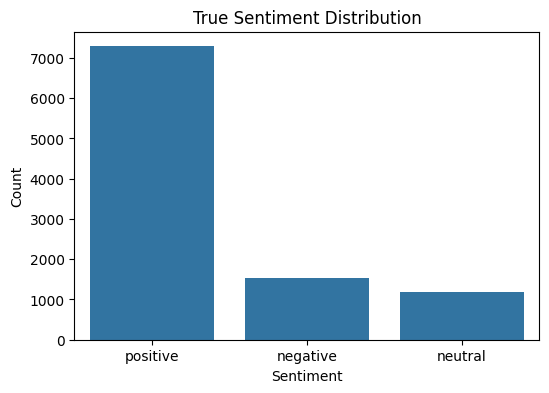

In [ ]:
#This graph shows the distribution of the actual sentiment labels
# It helps us see if the data is balanced or imbalanced.
plt.figure(figsize=(6,4))
sns.countplot(x='true_sentiment', data=df)
plt.title("True Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

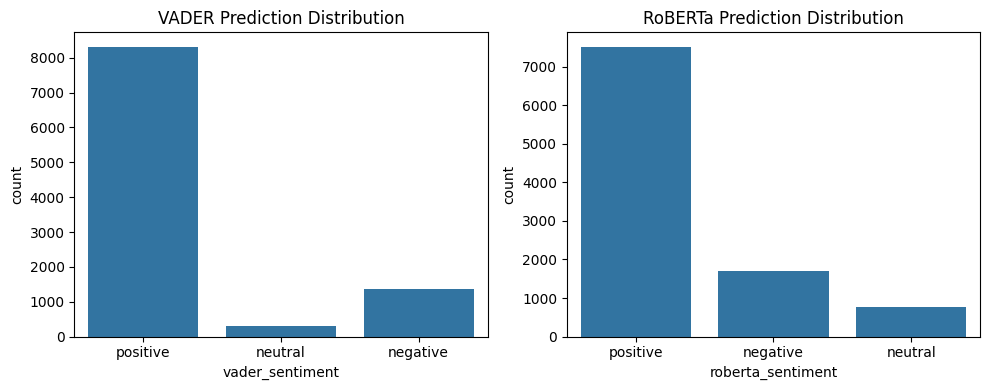

In [ ]:
# These graphs show how each model (VADER and RoBERTa)
# distributes its predicted sentiment classes.
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.countplot(x='vader_sentiment', data=df)
plt.title("VADER Prediction Distribution")

plt.subplot(1,2,2)
sns.countplot(x='roberta_sentiment', data=df)
plt.title("RoBERTa Prediction Distribution")

plt.tight_layout()
plt.show()

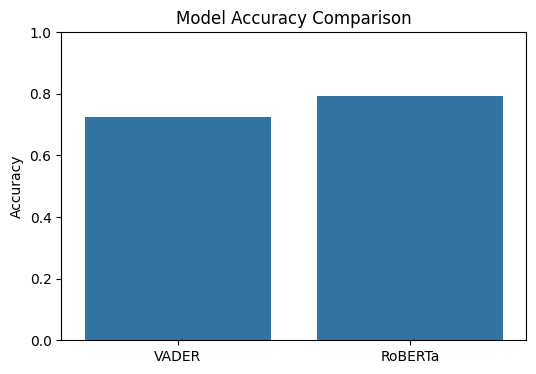

In [ ]:
# This graph compares the overall accuracy
# of VADER and RoBERTa models.
models = ['VADER', 'RoBERTa']
accuracies = [vader_acc, roberta_acc]

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=accuracies)
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.show()

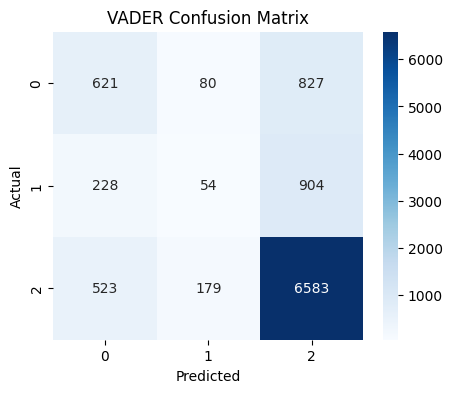

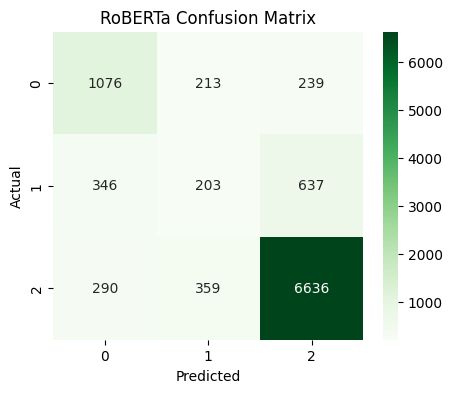

In [ ]:
# Confusion matrices show how many predictions were correct
# and where the models made mistakes.
# Diagonal values represent correct predictions.

# VADER
cm_vader = confusion_matrix(
    df['true_sentiment'],
    df['vader_sentiment']
)

plt.figure(figsize=(5,4))
sns.heatmap(cm_vader, annot=True, fmt='d', cmap='Blues')
plt.title("VADER Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# RoBERTa
cm_roberta = confusion_matrix(
    df['true_sentiment'],
    df['roberta_sentiment']
)

plt.figure(figsize=(5,4))
sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Greens')
plt.title("RoBERTa Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()